# Rotation Measures and Large-Scale Structure


NOTE: The code below is work in progress for students and colleagues working with Shea Brown at the University of Iowa. The code and data are free to use, but we do ask that you contact us at shea-brown@uiowa.edu if you plan on using this in a publication. 

This is code for loading and plotting Rotation-Measures (RMs) from Hammond et al. (2013) on an all-sky Healpix map of large-scale structure. We will use two example maps, the first being the WISE-SuperCOSMOS photometric catalog and the Cosmic-Flows3 catalog. First we will import the necessary libraries 

In [2]:
%matplotlib inline
import healpy as hp
import numpy as np
#import matplotlib.pyplot as plt
import pylab as plt
from astropy.io import fits
from matplotlib import cm



## Rotation Measures
We must then import the RM catalog of Hammond et al. (2013), which comes as a FITS table. It can be found here http://www.sifa.org.au/Main/RMCatalogue 

In [3]:
hdulist = fits.open('rm_redshift_catalog.fits')
data=hdulist[1].data
l=data['GLON']
b=data['GLAT']
rm=data['NVSS_RM']
drm=data['NVSS_RM_ERR']
z=data['SELECTED_REDSHIFT']

Let's only select the high redshift sources. 

In [4]:
l=l[z>1]
b=b[z>1]
rm=rm[z>1]
drm=drm[z>1]
z=z[z>1]

## Large Scale Structure from WISE-SuperCosmos
Now we will load in a Healpix image of the entire WISE-SuperCOSMOS catalog, along with a galactic mask. These come from Bilicki et al. (2016), and can be found here https://github.com/sheabrown/WHIM_Filament, where we used the data to detect filaments in front of the blazaer 1ES 1553+113. 

In [5]:
mask=hp.read_map('WISExSCOSmask.fits')
map=hp.read_map('wise_all.fits')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


## Plotting
Now we can plot the LSS map using the mollview() function within healpy, and then overplot the locations of the RMs from the catalog. In order to see the LSS a little easier, we convolve the map with a 2 degree gaussian kernal. At this point we don't care about the sign of the RMs, so we'll just represent the absolute value by the size of the circle. We also adjust the color map before plotting. 

Sigma is 50.955555 arcmin (0.014822 rad) 
-> fwhm is 119.991161 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


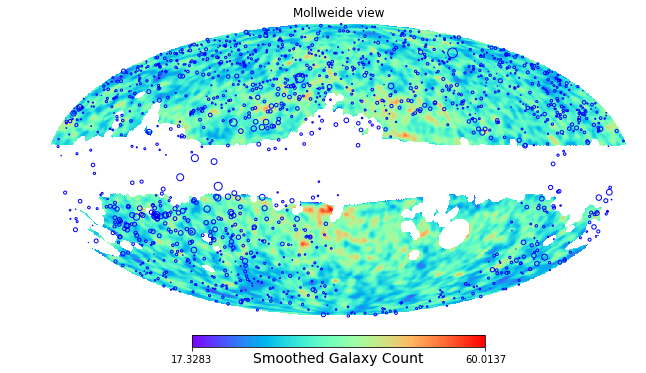

In [6]:
cool_map = cm.rainbow
cool_map.set_under("w")
smo=hp.smoothing(map,fwhm=2.0/57.3)
smo=hp.ma(smo)
smo.mask=np.logical_not(mask)
hp.mollview(smo,unit='Smoothed Galaxy Count', cmap=cool_map)

for i in range(len(rm)):
        hp.projscatter(l[i],b[i],lonlat=True,s=np.abs(rm[i])/5.,coord='G',linewidth=1,color='blue',facecolors='none')
        
plt.plot()
plt.show()

## Large-Scale Structure from CosmicFlows3
Let us try it out on the Cosmic-Flows3 data (Tully et al. 2016), which is lower redshift than the WISE-SuperCOSMOS catalog. 

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Sigma is 127.388886 arcmin (0.037056 rad) 
-> fwhm is 299.977903 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


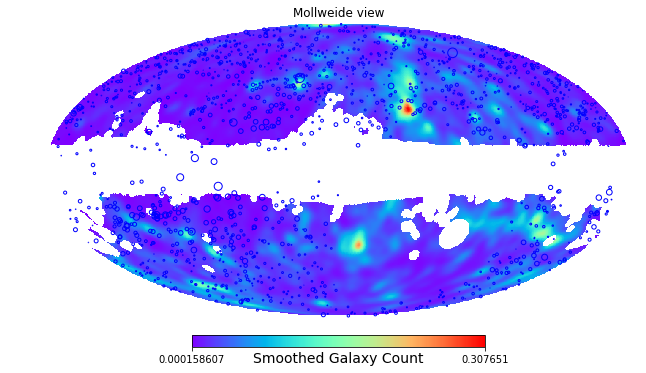

In [7]:
map=hp.read_map('cosmicflows3.fits')
smo=hp.smoothing(map,fwhm=5.0/57.3)
smo=hp.ma(smo)
smo.mask=np.logical_not(mask)
hp.mollview(smo,unit='Smoothed Galaxy Count', cmap=cool_map)

for i in range(len(rm)):
        hp.projscatter(l[i],b[i],lonlat=True,s=np.abs(rm[i])/5.,coord='G',linewidth=1,color='blue',facecolors='none')
        
plt.plot()
plt.show()

## Calculating Residule RMs
We must now estimate the Galactic contribution to the RMs before comparing with LSS. One possible way to start is to use the Galactic RMs extimated by Oppermann et al. (2011) using Bayesian Information Field Theory. The majority of the RMs used for this work came from the NVSS catalog; the same sample where the Hammond et al. (2013) RMs came from.  

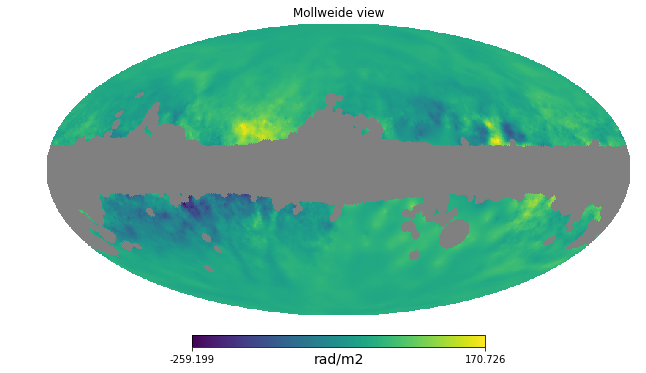

In [8]:
import h5py as h5
f = h5.File("foreground.hdf5", "r")
maps = f['maps']
phi = maps['phi'][:]
gal_rm = hp.ma(phi)
mask2 = hp.ud_grade(mask,128)
gal_rm.mask = np.logical_not(mask2)
hp.mollview(gal_rm,unit='rad/m2')

If we want to subtract out the Galactic contribution, we should average over many RMs, so let's take the median value within 5 degrees, in which case we'll need to define a function to do it. There are probably other out there, but this one is mine:

In [9]:
def filt_map_hp(nside,map,rad):
    rad=rad/57.3 #convert to radians
    med=np.ones(len(map))
    
    for i in range(hp.nside2npix(nside)):
        vec=hp.pix2vec(nside,i)
        local=hp.query_disc(nside,vec,rad)
        med[i]=np.median(map[local])

    return med

Now let's give it a try on the faraday map.

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:639: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Warning: converting a masked element to nan.
  
/usr/local/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/usr/local/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/usr/local/lib/python3.6/site-packages/healpy/projaxes.py:1053: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/usr/local/lib/python3.6/site-packages/healpy/projaxes.py:1054: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


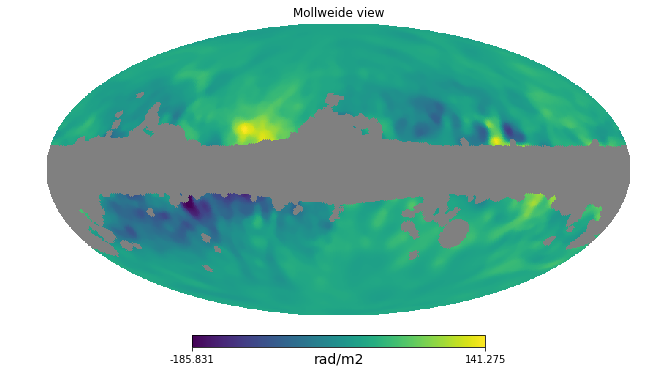

In [10]:
rm_med = filt_map_hp(128,gal_rm,2.5)
hp.mollview(rm_med,unit='rad/m2')

We would now like to subtract the median RM value at the location of each source from the catalog value to get the residule RM (RRM). 

In [11]:
rrm = np.ones(len(rm))
print(len(rrm))

for i in range(len(rm)):
    pix = hp.ang2pix(128,l[i],b[i],nest=False,lonlat=True)
    rrm[i] = rm[i] - rm_med[pix]

1521


We can look at how the values of changed:

1409 1409


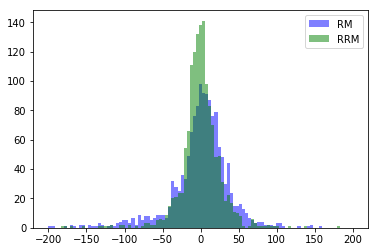

In [12]:
# Extract only values not in the mask
l = l[np.logical_not(np.isnan(rrm))]
b = b[np.logical_not(np.isnan(rrm))]
rm = rm[np.logical_not(np.isnan(rrm))]
rrm = rrm[np.logical_not(np.isnan(rrm))]
print(len(rrm),len(rm))

bins = np.linspace(-200, 200, 100)
plt.hist(rm, bins, alpha=0.5, label='RM',color='blue')
plt.hist(rrm, bins, alpha=0.5, label='RRM',color='green')
plt.legend(loc='upper right')

We will now extract the value of the forground map (smo is from Cosmicflows-3 data) at each source and plot if verse RRM.... who knows, we might get lucky!

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Warning: converting a masked element to nan.
  """


(0, 200)

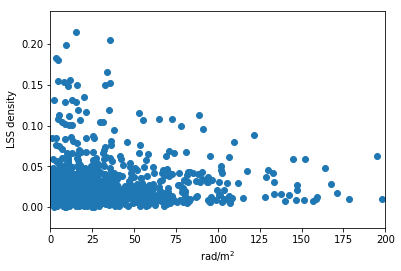

In [13]:
foreground = np.ones(len(l))

for i in range(len(rm)):
    pix = hp.ang2pix(128,l[i],b[i],nest=False,lonlat=True)
    foreground[i] = smo[pix]


plt.scatter(np.abs(rm),foreground)
plt.xlabel(r'rad/m$^2$')
plt.ylabel(r'LSS density')
plt.xlim(0,200)
#plt.ylim(0,0.2)

... we didn't. 